<a href="https://colab.research.google.com/github/praths007/tensorflow_certification/blob/master/coursera_practise/TS_week3_tuning_ts_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import tensorflow as tf

In [74]:
tf.__version__

'2.3.0'

In [75]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

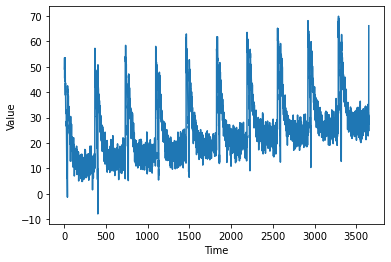

In [76]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [77]:
def window_dataset(series, window_size, shuffle_buffer_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [89]:
dataset = window_dataset(x_train, window_size, shuffle_buffer_size, batch_size)

model = Sequential([
                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                    Bidirectional(LSTM(40, return_sequences=True)),
                    Bidirectional(LSTM(40)),
                    # Dense(64, activation='relu'),
                    Dense(1),
                    tf.keras.layers.Lambda(lambda x:x*100)
])

In [90]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_30 (Lambda)           (None, None, 1)           0         
_________________________________________________________________
bidirectional_30 (Bidirectio (None, None, 80)          13440     
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 80)                38720     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 81        
_________________________________________________________________
lambda_31 (Lambda)           (None, 1)                 0         
Total params: 52,241
Trainable params: 52,241
Non-trainable params: 0
_________________________________________________________________


In [91]:
callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)
opt = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(optimizer=opt, loss=tf.keras.losses.Huber())

history = model.fit(dataset, epochs=100, callbacks=[callback], verbose=0)

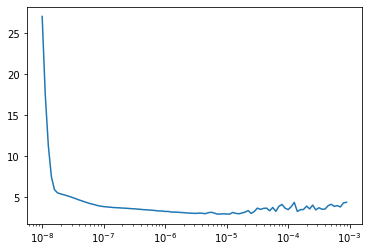

In [92]:
plt.semilogx(history.history['lr'], history.history['loss'])
# plt.axis([1e-8, 1e-4, 0, 30])

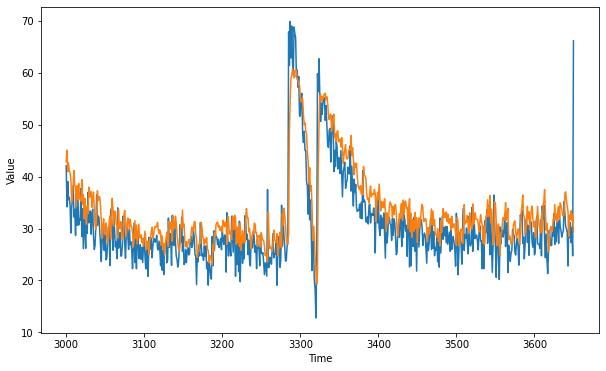

In [93]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [96]:
tf.metrics.mae(x_valid, results)

<tf.Tensor: shape=(), dtype=float32, numpy=4.2546>

In [104]:
tf.keras.backend.clear_session()

dataset = window_dataset(x_train, window_size, shuffle_buffer_size, batch_size=128)

model = Sequential([
                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1), input_shape=[None]),
                    Bidirectional(LSTM(64, return_sequences=True)),
                    Bidirectional(LSTM(64)),
                    Dense(16, activation='relu'),
                    Dense(1),
                    tf.keras.layers.Lambda(lambda x:x*100)
])


In [105]:
callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

optim = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])

history = model.fit(dataset, epochs=100, callbacks=[callback])

Epoch 1/100
24/24 [==============================] - 0s 12ms/step - loss: 25.1366 - mae: 25.6366
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 25.1341 - mae: 25.6341
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 25.1311 - mae: 25.6311
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 25.1277 - mae: 25.6277
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 25.1240 - mae: 25.6240
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 25.1201 - mae: 25.6201
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 25.1155 - mae: 25.6155
Epoch 8/100
24/24 [==============================] - 0s 15ms/step - loss: 25.1103 - mae: 25.6103
Epoch 9/100
24/24 [==============================] - 0s 14ms/step - loss: 25.1046 - mae: 25.6046
Epoch 10/100
24/24 [==============================] - 0s 14ms/step - loss: 25.0981 - mae: 25.5981
Epoch 11/100
24/24 [=========

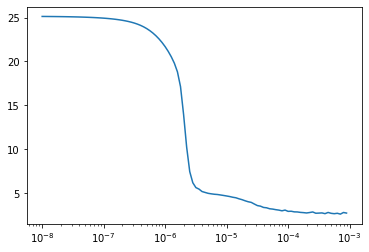

In [109]:
plt.semilogx(history.history['lr'], history.history['loss'])
# plt.axis([1e-8, 1e-4, 0, 30])

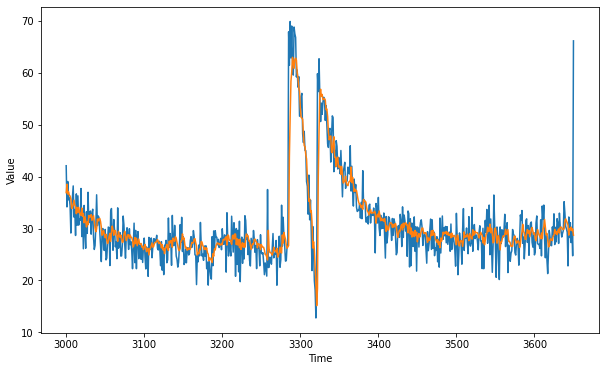

In [107]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [108]:
tf.metrics.mae(x_valid, results)

<tf.Tensor: shape=(), dtype=float32, numpy=2.9356875>